# Description
Train multilayer perceptron encoders with 1 hidden layer (or 2 optical fully connected layers) for the extended cell-organelle dataset.

# Load Libraries

In [1]:
from __future__ import print_function
import os, sys
import math
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR
import optuna
import ray

import wandb
from torchvision import datasets, transforms

In [2]:
""" Training and hyperparameter search configurations """

parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=600, metavar='N',
                    help='number of epochs to train (default: 100)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--gpus', default=0,
                    help='gpus used for training - e.g 0,1,3')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--wandb', action='store_true', default=True, 
                    help='enables wandb logger')  
parser.add_argument('--csv', action='store_true', default=False, 
                    help='enables csv logger')  
args = parser.parse_args("")
args.cuda = not args.no_cuda and torch.cuda.is_available()

# Set random seeds to reproduce results
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Data loaders

In [3]:
""" Construct a dataset object from data. """

class EBI_Cell_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_import, label_import, data_transforms=None):
        self.physical_ground_truth = torch.tensor(data_import, dtype = torch.float32)
        self.labels = torch.tensor(label_import, dtype = torch.long)
        self.class_dict = {}
        self.transform = data_transforms
                
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        data = self.physical_ground_truth[idx]
        
        if self.transform:
             data = self.transform(self.physical_ground_truth[idx].unsqueeze(0))
            
        return data, self.labels[idx]

In [4]:
""" Prepare data loaders """
data = np.load('./EBI_Cells_grey_w_anomaly3.npz', allow_pickle=True)
train_np = data['train_data_grey']
train_labels = data['train_labels']
val_np = data['val_data_grey']
val_labels = data['val_labels']
test_np = data['test_data_grey']
test_labels = data['test_labels']

transforms_digi = transforms.Compose([transforms.Lambda(lambda x: x.view(-1)), \
                                      transforms.Lambda(lambda x: x)])

transforms_digi_distort = transforms.Compose([transforms.RandomAffine(0, translate=(0.05, 0.05), scale=(0.96, 1.04)), \
                                              transforms.Lambda(lambda x: x.view(-1)), \
                                              transforms.Lambda(lambda x: x)])
kwargs = {}

""" input image loader w/. customerized samplers """
train_sampler = torch.utils.data.BatchSampler(\
                                              torch.utils.data.RandomSampler(range(train_labels.shape[0])), \
                                              batch_size=args.batch_size, drop_last=False)
val_sampler = torch.utils.data.BatchSampler(\
                                              torch.utils.data.RandomSampler(range(val_labels.shape[0])), \
                                              batch_size=args.test_batch_size, drop_last=False)
test_sampler = torch.utils.data.BatchSampler(\
                                             torch.utils.data.RandomSampler(range(test_labels.shape[0])), \
                                             batch_size=30000, drop_last=False)

train_loader = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(train_np, train_labels, transforms_digi), 
    batch_sampler=train_sampler, **kwargs)

val_loader = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(val_np, val_labels, transforms_digi), 
    batch_sampler=val_sampler, **kwargs)

test_loader = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(test_np, test_labels, transforms_digi), 
    batch_sampler=test_sampler, **kwargs)

data_loader = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(np.concatenate((test_np, val_np, train_np), axis=0), np.concatenate((test_labels, val_labels, train_labels), axis=0), transforms_digi), 
    batch_size=100000, shuffle=False, **kwargs)

# test_loader_phys = torch.utils.data.DataLoader( \
#     GT_Quickdraw_Dataset(test_np, test_labels, transforms_phys), \
#     batch_sampler=test_sampler, **kwargs)

# train_loader_phys_order = torch.utils.data.DataLoader( \
#     GT_Quickdraw_Dataset(train_np, train_labels, transforms_phys), \
#     batch_size=3000, shuffle=False, **kwargs)

# test_loader_phys = torch.utils.data.DataLoader( \
#     GT_Quickdraw_Dataset(test_np, test_labels, transforms_phys), \
#     batch_size=505, shuffle=False, **kwargs)

In [5]:
print(next(enumerate(data_loader))[1][0].shape)
print(next(enumerate(train_loader))[1][0].shape)
print(next(enumerate(val_loader))[1][0].shape)
print(next(enumerate(test_loader))[1][0].shape)

torch.Size([93050, 10000])
torch.Size([128, 10000])
torch.Size([1000, 10000])
torch.Size([9300, 10000])


# NN Models

In [6]:
class ONNLinear(nn.Module):
    def __init__(self, in_features, out_features, weight_noise=0.02, zeros_init=False):
        super(ONNLinear, self).__init__()
        self.W_Opt = \
            nn.Parameter(torch.randn(out_features, in_features, requires_grad = True) / math.sqrt(in_features)) \
            if not zeros_init else \
            nn.Parameter(torch.zeros(out_features, in_features, requires_grad = True)) 
        self.noise = weight_noise
        
    def forward(self, x):
        self.W_Opt.data = self.W_Opt.data.clamp_(0,1)
        out = F.linear(x + self.noise*torch.rand(x.shape, requires_grad=False, device=x.device), self.W_Opt)
        return out

def exp(Y, params):
    return torch.exp(-1.*torch.mul(Y, params))

def NL_func(Y, nonlinear_paramters):
    return torch.relu(torch.add(-1.*torch.mul(exp(Y, nonlinear_paramters[:, 1]), nonlinear_paramters[:, 0]) + \
                      -1.*torch.mul(exp(Y, nonlinear_paramters[:, 3]), nonlinear_paramters[:, 2]), \
                      nonlinear_paramters[:, 0]+nonlinear_paramters[:, 2])/50)

class ONNIntensifier(nn.Module):
    def __init__(self, func, coeffs):
        super(ONNIntensifier, self).__init__()
        self.func = func
        self.params = coeffs
        
    def forward(self, x):
        out = self.func(x, self.params)
        return out

In [7]:
class digitalClassifier(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.fcs = nn.ModuleList([nn.Linear(i,j,**kwargs) for i, j in zip(Nunits[:-1], Nunits[1:])])

    def forward(self, X):
        X = X.view(X.size(0), -1)
        for i, fc in enumerate(self.fcs):
            X = fc(X)
            if fc is not self.fcs[-1]:
                X = F.relu(X)
        return X

class OpticalClassifier(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.narrow(torch.tensor(coeffs, dtype=torch.float32), 0, 32, 1), requires_grad = False)
        modules = []
        modules.append(ONNLinear(Nunits[0], Nunits[1], zeros_init=False)) 
        for l in range(1, len(Nunits)-1):
            modules.append(ONNIntensifier(NL_func, self.coeffs))
            modules.append(ONNLinear(Nunits[l], Nunits[l+1], zeros_init=False)) 
        self.encoder_nn = nn.Sequential(*modules)
        compressed_size = Nunits[-1]
        self.digifc = nn.Linear(compressed_size, 10, bias=True)
            
    def forward(self, x):
        x = self.encoder_nn(x)
        y = self.digifc(x)
        return y

In [9]:
 """ helper functions and classes """
    
# A manager for dynamical book-keeping of the top k accuracies and model checkpoints during training
class top_k_manager(object):
    def __init__(self, k=10):
        self.k_best = k
        self.top_k_metric =[0]*self.k_best
        self.top_k_paths = [""]*self.k_best
    
    # Compare the new_metric to the top k metrics in the past, and find its place.
    def update_rank(self, new_metric, path_keeping):
        for rank, record_metric in enumerate(self.top_k_metric):
            if record_metric <= new_metric:    
                if os.path.exists(self.top_k_paths[-1]):
                    os.remove(self.top_k_paths[-1])
                if rank < self.k_best - 1:
                    self.top_k_metric[rank+1:] = self.top_k_metric[rank:-1]
                    self.top_k_paths[rank+1:] = self.top_k_paths[rank:-1]  
                self.top_k_metric[rank] = new_metric
                self.top_k_paths[rank] = path_keeping
                return True # the top k list has been updated
        return False
    
# A simple hook class that returns the input and output of a layer during forward/backward pass
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

# Define training and testing functions


In [10]:
def train(epoch, model, optimizer, criterion, train_loader0):
    model.train()
    # Loop around mini-batches in an epoch
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader0):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        
        optimizer.step()
        
        pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        """
        if batch_idx % args.log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
            +f" ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
        """
        if args.wandb:
            wandb.log({"train_loss": loss.item(), "batch": batch_idx}, step = epoch)
            
    accuracy = 100.0 * correct/len(train_loader0.dataset)
    print(f"Train Epoch: {epoch} \t\tLoss: {loss.item():.6f}\tAccuracy: {accuracy: .2f}%")

def test(epoch, model, criterion, test_loader0):
    model.eval()
    test_loss = 0
    correct = 0
    hks = {"fc1": Hook(model.encoder_nn[0]), "act1": Hook(model.encoder_nn[1]), "fc2": Hook(model.encoder_nn[2])}
    # Loop around mini-batches in an epoch
    with torch.no_grad():
        for data, target in test_loader0:
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            outputs = model(data)
            test_loss += criterion(outputs, target).item() # sum up batch loss
            pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader0)
    accuracy = 100. * correct / len(test_loader0.dataset)
    val_stats = {"val_loss": test_loss, "accuracy": accuracy}
    for k in hks.keys():
        val_stats[k] = wandb.Histogram(hks[k].output.cpu())      
    
    if epoch%1 == 0:
        print(f"\nTest set: Epoch {epoch}, Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader0.dataset)}" 
              +f"({accuracy:.0f}%)\n")

    if args.wandb:
        wandb.log(val_stats, step=epoch)
    return test_loss, accuracy

In [19]:
""" The objective function runs a trial in a NAS study (a loop around epochs) """

def objective(trial, NAS_project_name, gpu_id, train_loader0, test_loader0):

    # Define the hyperparameter search space
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    lr_factor0 = 0.005
    lr_factor = trial.suggest_uniform("lrf", lr_factor0/2, lr_factor0*4)
    learning_rate = lr_factor * np.sqrt(batch_size/128)
    swa_lr = trial.suggest_uniform("swa_lr", 0.0001, 0.0005)
    beta1 = trial.suggest_uniform("beta1", 0.99, 0.9999)
    beta2 = trial.suggest_uniform("beta2", 0.999, 0.9999)
    swa_start = trial.suggest_categorical("swa_start", [300, 400, 500])
#     warmup_epochs = trial.suggest_categorical("warmup_eps", [18, 24, 30])
    #model_description = f"Autoencoder_QAT_ar5wd5_lr_{learning_rate:.3f}_{lr_decay:.2f}" + f"_m_{momentum:.2f}" + f"_wp_{warmup_epochs}"+ f"_v_{trial.number}"
    model_description = f"Classifier_200_20_b{batch_size}_AdamW_lr_{learning_rate:.6f}_bs_{batch_size}_betas_{beta1:.4f}_{beta2:.4f}_swa_{swa_start}_{swa_lr:.4f}" + f"_v_{trial.number}"

    # Instantiate a BNN model
    model = OpticalClassifier([100**2, 200, 20])

    if args.cuda:
        torch.cuda.set_device(gpu_id)
        model.cuda() # transfer the model from cpu to gpu
    
    # Set up logging if necessary
    if args.wandb:
        wandb.init(project=NAS_project_name, name=model_description, reinit=True)
        wandb.watch(model, log="all")

    # Configure loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(beta1, beta2), weight_decay=0e-4)
    
    swa_model = AveragedModel(model)
    scheduler = CosineAnnealingLR(optimizer, T_max=swa_start+50)
    swa_scheduler = SWALR(optimizer, swa_lr=swa_lr)
    
    train_loader0.batch_sampler.batch_size = batch_size

    # Loop around epoches
    tpk_mngr = top_k_manager()
    ckpt_save_path = "./" + model_description
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
    for epoch in range(1, args.epochs + 1):
        train(epoch, model, optimizer, criterion, train_loader0)
        loss, accu = test(epoch, model, criterion, test_loader0)
        # schedule learning rate decay
        if epoch > swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            scheduler.step()
        # Save the best models aftering the training gets more stable
        if epoch > 30:
            if tpk_mngr.update_rank(accu, ckpt_save_path+f"/ep{epoch}.pt"):
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                }, ckpt_save_path+f"/ep{epoch}.pt")

    # Log the best models
    trial.set_user_attr('top 3 accuracy', torch.tensor(tpk_mngr.top_k_metric[:3]).mean().item()) # Save the best accuracy during the taining loop      
    if args.wandb:
        wandb.run.summary["top_k_accu"] = tpk_mngr.top_k_metric
        wandb.run.summary["top_k_paths"] = tpk_mngr.top_k_paths
    return torch.tensor(tpk_mngr.top_k_metric[:5]).mean().item() # return the average of top k accuracies to guide NAS

In [20]:
""" Remote projects for NAS by running an optuna study on a thread """

@ray.remote(num_cpus=0.2, num_gpus=0.2)
class Parallel_NAS_project(object):
    def __init__(self, NAS_project_name, rseed, gpu_id):
        os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
        torch.cuda.set_device(gpu_id)
        self.sampler = optuna.samplers.TPESampler(seed=rseed) 
        self.storage = f'sqlite:///'+NAS_project_name+'.db' # way to specify an SQL database
        self.study = optuna.create_study(study_name=NAS_project_name, storage=self.storage, 
                                sampler=self.sampler, direction="maximize", load_if_exists=True)
    
    def runStudy(self, gpu_id, train_loader, test_loader):
        self.study.optimize(lambda trial: objective(trial, NAS_project_name, gpu_id, train_loader, test_loader), n_trials=18)

In [22]:
""" Create remote projects for NAS """

ray.init(num_gpus=4, ignore_reinit_error=True)
gpu_list = [2,2,2]
rseeds = [213, 234, 657]

NAS_project_name = "Jun_30_H1_rev"
workerList = []
for (rseed, gpu_id) in zip(rseeds, gpu_list): 
    worker = Parallel_NAS_project.remote(NAS_project_name, rseed, gpu_id)
    workerList.append(worker)
    print(rseed, gpu_id) 

#train_loader_id = ray.put(train_loader) # important for large data loaders, since they would surpass memory limit if passed as parameters to study functions.
#test_loader_id = ray.put(test_loader)
remaining_ids = []
for i, w in enumerate(workerList):
    test_id = w.runStudy.remote(gpu_list[i], train_loader, val_loader)
    remaining_ids.append(test_id)

while remaining_ids:
    done_ids, remaining_ids = ray.wait(remaining_ids)
    result_id = done_ids[0]
    print(done_ids, remaining_ids)
    ray.get(result_id)
    
ray.shutdown()

2022-07-04 16:39:25,412	INFO worker.py:879 -- Calling ray.init() again after it has already been called.


213 2
234 2
657 2


(Parallel_NAS_project pid=38676) [I 2022-07-04 16:39:29,826] Using an existing study with name 'Jun_30_H1_rev' instead of creating a new one.
(Parallel_NAS_project pid=38625) [I 2022-07-04 16:39:29,977] Using an existing study with name 'Jun_30_H1_rev' instead of creating a new one.
(Parallel_NAS_project pid=38780) [I 2022-07-04 16:39:30,005] Using an existing study with name 'Jun_30_H1_rev' instead of creating a new one.
(Parallel_NAS_project pid=38780) wandb: Currently logged in as: gangsterkitty (use `wandb login --relogin` to force relogin)
(Parallel_NAS_project pid=38780) 2022-07-04 16:40:22.355183: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(Parallel_NAS_project pid=38780) 2022-07-04 16:40:22.355233: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your mach

(Parallel_NAS_project pid=38780) Train Epoch: 1 		Loss: 1.121545	Accuracy:  55.57%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 1, Average loss: 1.0732, Accuracy: 18887/27916(68%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38625) Train Epoch: 1 		Loss: 0.869736	Accuracy:  45.23%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 1, Average loss: 1.3223, Accuracy: 16623/27916(60%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) Train Epoch: 1 		Loss: 1.441099	Accuracy:  42.61%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 1, Average loss: 1.3431, Accuracy: 16991/27916(61%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38780) Train Epoch: 2 		Loss: 0.816666	Accuracy:  70.03%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 2, Average loss: 0.9726, Accuracy: 19535/27916(70%)
(Parallel_NAS_project pid=

(Parallel_NAS_project pid=38780) Test set: Epoch 22, Average loss: 0.6583, Accuracy: 22503/27916(81%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) Train Epoch: 23 		Loss: 1.031121	Accuracy:  81.29%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 23, Average loss: 0.7072, Accuracy: 22179/27916(79%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) Train Epoch: 22 		Loss: 0.740311	Accuracy:  82.27%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 22, Average loss: 0.6925, Accuracy: 22184/27916(79%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38780) Train Epoch: 23 		Loss: 0.790943	Accuracy:  83.84%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 23, Average loss: 0.6848, Accuracy: 22081/27916(79%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) Train Epoch: 24 		Loss: 0.461374	Accuracy:  82.00%
(Parallel_NAS_proj

(Parallel_NAS_project pid=38625) Test set: Epoch 42, Average loss: 0.6346, Accuracy: 22644/27916(81%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38780) Train Epoch: 43 		Loss: 0.378640	Accuracy:  85.78%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 43, Average loss: 0.6638, Accuracy: 22466/27916(80%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) Train Epoch: 46 		Loss: 0.348164	Accuracy:  84.34%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 46, Average loss: 0.6483, Accuracy: 22504/27916(81%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) Train Epoch: 43 		Loss: 0.459313	Accuracy:  85.28%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 43, Average loss: 0.6457, Accuracy: 22509/27916(81%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38780) Train Epoch: 44 		Loss: 0.356058	Accuracy:  86.69%
(Parallel_NAS_proj

(Parallel_NAS_project pid=38676) Test set: Epoch 68, Average loss: 0.6165, Accuracy: 22768/27916(82%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) Train Epoch: 63 		Loss: 0.257433	Accuracy:  85.97%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 63, Average loss: 0.6369, Accuracy: 22658/27916(81%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38780) Train Epoch: 64 		Loss: 0.196482	Accuracy:  86.57%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 64, Average loss: 0.6182, Accuracy: 22897/27916(82%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) Train Epoch: 69 		Loss: 0.130795	Accuracy:  86.96%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 69, Average loss: 0.6306, Accuracy: 22690/27916(81%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) Train Epoch: 64 		Loss: 0.232177	Accuracy:  85.97%
(Parallel_NAS_proj

(Parallel_NAS_project pid=38625) Test set: Epoch 83, Average loss: 0.6058, Accuracy: 22932/27916(82%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) Train Epoch: 92 		Loss: 0.278906	Accuracy:  89.00%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 92, Average loss: 0.5843, Accuracy: 23099/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38780) Train Epoch: 84 		Loss: 0.570606	Accuracy:  87.85%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 84, Average loss: 0.7200, Accuracy: 21872/27916(78%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38625) Train Epoch: 84 		Loss: 0.278827	Accuracy:  86.81%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 84, Average loss: 0.6402, Accuracy: 22727/27916(81%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) Train Epoch: 93 		Loss: 0.338301	Accuracy:  88.58%
(Parallel_NAS_proj

(Parallel_NAS_project pid=38676) Test set: Epoch 115, Average loss: 0.5837, Accuracy: 23043/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38780) Train Epoch: 104 		Loss: 0.342817	Accuracy:  87.97%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 104, Average loss: 0.6645, Accuracy: 22824/27916(82%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) Train Epoch: 116 		Loss: 0.306581	Accuracy:  89.94%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 116, Average loss: 0.5784, Accuracy: 23149/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) Train Epoch: 104 		Loss: 0.192372	Accuracy:  87.97%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 104, Average loss: 0.6102, Accuracy: 22917/27916(82%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38780) Train Epoch: 105 		Loss: 0.430128	Accuracy:  88.87%
(Parallel_

(pid=38272) Exception in thread ray_import_thread:
(pid=38272) Traceback (most recent call last):
(pid=38272)   File "/usr/local/anaconda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
(pid=38272)     self.run()
(pid=38272)   File "/usr/local/anaconda/lib/python3.7/threading.py", line 870, in run
(pid=38272)     self._target(*self._args, **self._kwargs)
(pid=38272)   File "/home/tianyu/.local/lib/python3.7/site-packages/ray/_private/import_thread.py", line 71, in _run
(pid=38272)     key = self.subscriber.poll()
(pid=38272)   File "/home/tianyu/.local/lib/python3.7/site-packages/ray/_private/gcs_pubsub.py", line 409, in poll
(pid=38272)     self._poll_locked(timeout=timeout)
(pid=38272)   File "/home/tianyu/.local/lib/python3.7/site-packages/ray/_private/gcs_pubsub.py", line 263, in _poll_locked
(pid=38272)     self._poll_request(), timeout=timeout)
(pid=38272)   File "/home/tianyu/.local/lib/python3.7/site-packages/grpc/_channel.py", line 976, in future
(pid=38272)     (op

(pid=38127)   File "/home/tianyu/.local/lib/python3.7/site-packages/grpc/_channel.py", line 976, in future
(pid=38127)     (operations,), event_handler, self._context)
(pid=38127)   File "/home/tianyu/.local/lib/python3.7/site-packages/grpc/_channel.py", line 1306, in create
(pid=38127)     _run_channel_spin_thread(state)
(pid=38127)   File "/home/tianyu/.local/lib/python3.7/site-packages/grpc/_channel.py", line 1270, in _run_channel_spin_thread
(pid=38127)     channel_spin_thread.start()
(pid=38127)   File "src/python/grpcio/grpc/_cython/_cygrpc/fork_posix.pyx.pxi", line 117, in grpc._cython.cygrpc.ForkManagedThread.start
(pid=38127)   File "/usr/local/anaconda/lib/python3.7/threading.py", line 852, in start
(pid=38127)     _start_new_thread(self._bootstrap, ())
(pid=38127) RuntimeError: can't start new thread
(pid=38127) 
(pid=38015) Exception in thread ray_import_thread:
(pid=38015) Traceback (most recent call last):
(pid=38015)   File "/usr/local/anaconda/lib/python3.7/threading.py

(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 134, Average loss: 0.5976, Accuracy: 22966/27916(82%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 118, Average loss: 0.6739, Accuracy: 22809/27916(82%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38625) Train Epoch: 118 		Loss: 0.877146	Accuracy:  88.07%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 118, Average loss: 0.6348, Accuracy: 22705/27916(81%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) Train Epoch: 135 		Loss: 0.293028	Accuracy:  90.19%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 135, Average loss: 0.5888, Accuracy: 23045/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38780) Train Epoch: 119 		Loss: 0.344400	Accuracy:  89.28%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=3

(Parallel_NAS_project pid=38780) Test set: Epoch 138, Average loss: 0.6434, Accuracy: 22925/27916(82%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) Train Epoch: 158 		Loss: 0.296741	Accuracy:  91.24%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 158, Average loss: 0.5817, Accuracy: 23080/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) Train Epoch: 138 		Loss: 0.267508	Accuracy:  88.94%
(Parallel_NAS_project pid=38780) Train Epoch: 139 		Loss: 0.429836	Accuracy:  89.43%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 138, Average loss: 0.5781, Accuracy: 23194/27916(83%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 139, Average loss: 0.6512, Accuracy: 22938/27916(82%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) Train Epoch: 159 		Loss: 0.228162	Accuracy:  90.99%
(Parallel_

(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 181, Average loss: 0.5779, Accuracy: 23216/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38780) Train Epoch: 159 		Loss: 0.574835	Accuracy:  89.73%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 159, Average loss: 0.6893, Accuracy: 22738/27916(81%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) Train Epoch: 182 		Loss: 0.171716	Accuracy:  91.97%
(Parallel_NAS_project pid=38625) Train Epoch: 158 		Loss: 0.385796	Accuracy:  89.32%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 182, Average loss: 0.5842, Accuracy: 23183/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 158, Average loss: 0.5880, Accuracy: 23159/27916(83%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38780) Train Epoch: 160 		Loss: 0.3

(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 177, Average loss: 0.6076, Accuracy: 22968/27916(82%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38780) Train Epoch: 179 		Loss: 0.164920	Accuracy:  90.48%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 179, Average loss: 0.7153, Accuracy: 22634/27916(81%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) Train Epoch: 206 		Loss: 0.300541	Accuracy:  92.28%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 206, Average loss: 0.5797, Accuracy: 23246/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) Train Epoch: 178 		Loss: 0.390756	Accuracy:  89.81%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 178, Average loss: 0.6988, Accuracy: 22288/27916(80%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) Train Epoch: 207 		Loss: 0.1

(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 230, Average loss: 0.5809, Accuracy: 23247/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38780) Train Epoch: 199 		Loss: 0.209019	Accuracy:  91.58%
(Parallel_NAS_project pid=38625) Train Epoch: 197 		Loss: 0.355099	Accuracy:  89.78%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 199, Average loss: 0.6644, Accuracy: 22894/27916(82%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 197, Average loss: 0.6225, Accuracy: 23029/27916(82%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) Train Epoch: 231 		Loss: 0.264005	Accuracy:  92.50%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 231, Average loss: 0.5854, Accuracy: 23160/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38780) Train Epoch: 200 		Loss: 0.3

(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 219, Average loss: 0.6797, Accuracy: 22811/27916(82%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) Train Epoch: 254 		Loss: 0.188382	Accuracy:  93.00%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 254, Average loss: 0.5808, Accuracy: 23165/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) Train Epoch: 217 		Loss: 0.325640	Accuracy:  90.16%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 217, Average loss: 0.6075, Accuracy: 23023/27916(82%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) Train Epoch: 255 		Loss: 0.207286	Accuracy:  92.96%
(Parallel_NAS_project pid=38780) Train Epoch: 220 		Loss: 0.122288	Accuracy:  91.72%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 255, Average loss: 0.5851, Accuracy: 23177/27916(83%)
(Parallel_

(Parallel_NAS_project pid=38625) Train Epoch: 236 		Loss: 0.200791	Accuracy:  90.30%
(Parallel_NAS_project pid=38676) Train Epoch: 279 		Loss: 0.241842	Accuracy:  93.47%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 239, Average loss: 0.6667, Accuracy: 23087/27916(83%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 236, Average loss: 0.6150, Accuracy: 22928/27916(82%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 279, Average loss: 0.5877, Accuracy: 23211/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Train Epoch: 280 		Loss: 0.297090	Accuracy:  93.35%
(Parallel_NAS_project pid=38780) Train Epoch: 240 		Loss: 0.383712	Accuracy:  92.58%
(Parallel_NAS_project pid=38625) Train Epoch: 237 		Loss: 0.947669	Accuracy:  90.81%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38

(Parallel_NAS_project pid=38780) Test set: Epoch 258, Average loss: 0.6631, Accuracy: 23060/27916(83%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 255, Average loss: 0.6240, Accuracy: 23029/27916(82%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 304, Average loss: 0.6008, Accuracy: 23088/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Train Epoch: 305 		Loss: 0.276694	Accuracy:  93.32%
(Parallel_NAS_project pid=38780) Train Epoch: 259 		Loss: 0.360943	Accuracy:  91.20%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 305, Average loss: 0.5907, Accuracy: 23153/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) Train Epoch: 256 		Loss: 0.498873	Accuracy:  90.50%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 259, Average

(Parallel_NAS_project pid=38780) Train Epoch: 278 		Loss: 0.226018	Accuracy:  92.93%
(Parallel_NAS_project pid=38676) Train Epoch: 329 		Loss: 0.192423	Accuracy:  93.56%
(Parallel_NAS_project pid=38625) Train Epoch: 275 		Loss: 0.478218	Accuracy:  91.24%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 329, Average loss: 0.5935, Accuracy: 23127/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 278, Average loss: 0.6567, Accuracy: 22936/27916(82%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 275, Average loss: 0.6000, Accuracy: 23223/27916(83%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) Train Epoch: 330 		Loss: 0.291752	Accuracy:  93.48%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 330, Average loss: 0.5917, Accuracy: 23224/27916(83%)
(Parallel_

(Parallel_NAS_project pid=38780) Train Epoch: 297 		Loss: 0.113945	Accuracy:  92.96%
(Parallel_NAS_project pid=38676) Train Epoch: 355 		Loss: 0.381256	Accuracy:  93.89%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 297, Average loss: 0.6328, Accuracy: 23210/27916(83%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 355, Average loss: 0.5855, Accuracy: 23256/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) Train Epoch: 294 		Loss: 0.289510	Accuracy:  91.58%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 294, Average loss: 0.5948, Accuracy: 23156/27916(83%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) Train Epoch: 356 		Loss: 0.167490	Accuracy:  94.03%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 356, Average loss: 0.6073, Accuracy: 23164/27916(83%)
(Parallel_

(Parallel_NAS_project pid=38625) Test set: Epoch 313, Average loss: 0.6378, Accuracy: 22836/27916(82%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) Train Epoch: 379 		Loss: 0.087996	Accuracy:  94.22%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 379, Average loss: 0.5849, Accuracy: 23222/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38780) Train Epoch: 317 		Loss: 0.385937	Accuracy:  93.26%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 317, Average loss: 0.6796, Accuracy: 22969/27916(82%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38625) Train Epoch: 314 		Loss: 0.151784	Accuracy:  91.87%
(Parallel_NAS_project pid=38676) Train Epoch: 380 		Loss: 0.250959	Accuracy:  94.08%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 380, Average loss: 0.5861, Accuracy: 23284/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_

(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 403, Average loss: 0.5888, Accuracy: 23261/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) Train Epoch: 333 		Loss: 0.205928	Accuracy:  91.95%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 333, Average loss: 0.5841, Accuracy: 23343/27916(84%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) Train Epoch: 404 		Loss: 0.093341	Accuracy:  94.33%
(Parallel_NAS_project pid=38780) Train Epoch: 337 		Loss: 0.185628	Accuracy:  93.48%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 404, Average loss: 0.5920, Accuracy: 23244/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 337, Average loss: 0.6658, Accuracy: 23204/27916(83%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38625) Train Epoch: 334 		Loss: 0.1

(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 427, Average loss: 0.5893, Accuracy: 23242/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) Train Epoch: 353 		Loss: 0.152908	Accuracy:  92.93%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 353, Average loss: 0.5955, Accuracy: 23207/27916(83%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) Train Epoch: 428 		Loss: 0.091833	Accuracy:  94.48%
(Parallel_NAS_project pid=38780) Train Epoch: 357 		Loss: 0.126458	Accuracy:  94.19%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 428, Average loss: 0.5883, Accuracy: 23267/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 357, Average loss: 0.6526, Accuracy: 23019/27916(82%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38625) Train Epoch: 354 		Loss: 0.3

(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 451, Average loss: 0.5933, Accuracy: 23261/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) Train Epoch: 373 		Loss: 0.277647	Accuracy:  92.65%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 373, Average loss: 0.6117, Accuracy: 23147/27916(83%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) Train Epoch: 452 		Loss: 0.091880	Accuracy:  94.52%
(Parallel_NAS_project pid=38780) Train Epoch: 377 		Loss: 0.078361	Accuracy:  94.35%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 452, Average loss: 0.5896, Accuracy: 23246/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 377, Average loss: 0.6394, Accuracy: 23339/27916(84%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38625) Train Epoch: 374 		Loss: 0.1

(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 397, Average loss: 0.6267, Accuracy: 23261/27916(83%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38625) Train Epoch: 393 		Loss: 0.504548	Accuracy:  93.22%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 393, Average loss: 0.5992, Accuracy: 23243/27916(83%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) Train Epoch: 477 		Loss: 0.184977	Accuracy:  94.66%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 477, Average loss: 0.5897, Accuracy: 23265/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38780) Train Epoch: 398 		Loss: 0.061134	Accuracy:  94.98%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 398, Average loss: 0.6275, Accuracy: 23393/27916(84%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38625) Train Epoch: 394 		Loss: 0.3

(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 412, Average loss: 0.5973, Accuracy: 23158/27916(83%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38780) Train Epoch: 417 		Loss: 0.185499	Accuracy:  96.41%
(Parallel_NAS_project pid=38676) Train Epoch: 502 		Loss: 0.264525	Accuracy:  94.73%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 417, Average loss: 0.6351, Accuracy: 23253/27916(83%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 502, Average loss: 0.5879, Accuracy: 23241/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) Train Epoch: 413 		Loss: 0.193708	Accuracy:  93.50%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 413, Average loss: 0.5949, Accuracy: 23219/27916(83%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) Train Epoch: 503 		Loss: 0.1

(Parallel_NAS_project pid=38780) Train Epoch: 437 		Loss: 0.186294	Accuracy:  96.23%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 432, Average loss: 0.5970, Accuracy: 23203/27916(83%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 437, Average loss: 0.6222, Accuracy: 23410/27916(84%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) Train Epoch: 526 		Loss: 0.343743	Accuracy:  94.16%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 526, Average loss: 0.5955, Accuracy: 23285/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) Train Epoch: 433 		Loss: 0.224304	Accuracy:  93.56%
(Parallel_NAS_project pid=38780) Train Epoch: 438 		Loss: 0.279591	Accuracy:  96.17%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 433, Average loss: 0.6028, Accuracy: 23139/27916(83%)
(Parallel_

(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 458, Average loss: 0.6156, Accuracy: 23446/27916(84%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38625) Train Epoch: 453 		Loss: 0.225400	Accuracy:  93.93%
(Parallel_NAS_project pid=38676) Train Epoch: 548 		Loss: 0.639338	Accuracy:  94.49%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 548, Average loss: 0.5964, Accuracy: 23231/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 453, Average loss: 0.5843, Accuracy: 23343/27916(84%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38780) Train Epoch: 459 		Loss: 0.153283	Accuracy:  96.97%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 459, Average loss: 0.6127, Accuracy: 23380/27916(84%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) Train Epoch: 549 		Loss: 0.2

(Parallel_NAS_project pid=38625) Train Epoch: 473 		Loss: 0.117636	Accuracy:  93.97%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 473, Average loss: 0.5886, Accuracy: 23297/27916(83%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38780) Train Epoch: 479 		Loss: 0.225458	Accuracy:  97.23%
(Parallel_NAS_project pid=38676) Train Epoch: 571 		Loss: 0.244700	Accuracy:  94.47%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 479, Average loss: 0.6141, Accuracy: 23437/27916(84%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 571, Average loss: 0.5981, Accuracy: 23224/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) Train Epoch: 474 		Loss: 0.225739	Accuracy:  94.13%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 474, Average loss: 0.5827, Accuracy: 23319/27916(84%)
(Parallel_

(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 594, Average loss: 0.5987, Accuracy: 23267/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 493, Average loss: 0.5790, Accuracy: 23357/27916(84%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 499, Average loss: 0.6203, Accuracy: 23419/27916(84%)
(Parallel_NAS_project pid=38780) 


(Parallel_NAS_project pid=38625) Exception in thread ray_import_thread:
(Parallel_NAS_project pid=38625) Traceback (most recent call last):
(Parallel_NAS_project pid=38625)   File "/usr/local/anaconda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
(Parallel_NAS_project pid=38625)     self.run()
(Parallel_NAS_project pid=38625)   File "/usr/local/anaconda/lib/python3.7/threading.py", line 870, in run
(Parallel_NAS_project pid=38625)     self._target(*self._args, **self._kwargs)
(Parallel_NAS_project pid=38625)   File "/home/tianyu/.local/lib/python3.7/site-packages/ray/_private/import_thread.py", line 71, in _run
(Parallel_NAS_project pid=38625)     key = self.subscriber.poll()
(Parallel_NAS_project pid=38625)   File "/home/tianyu/.local/lib/python3.7/site-packages/ray/_private/gcs_pubsub.py", line 409, in poll
(Parallel_NAS_project pid=38625)     self._poll_locked(timeout=timeout)
(Parallel_NAS_project pid=38625)   File "/home/tianyu/.local/lib/python3.7/site-packages/ray/_

(pid=38327)   File "/home/tianyu/.local/lib/python3.7/site-packages/ray/_private/import_thread.py", line 71, in _run
(pid=38327)     key = self.subscriber.poll()
(pid=38327)   File "/home/tianyu/.local/lib/python3.7/site-packages/ray/_private/gcs_pubsub.py", line 409, in poll
(pid=38327)     self._poll_locked(timeout=timeout)
(pid=38327)   File "/home/tianyu/.local/lib/python3.7/site-packages/ray/_private/gcs_pubsub.py", line 263, in _poll_locked
(pid=38327)     self._poll_request(), timeout=timeout)
(pid=38327)   File "/home/tianyu/.local/lib/python3.7/site-packages/grpc/_channel.py", line 976, in future
(pid=38327)     (operations,), event_handler, self._context)
(pid=38327)   File "/home/tianyu/.local/lib/python3.7/site-packages/grpc/_channel.py", line 1306, in create
(pid=38327)     _run_channel_spin_thread(state)
(pid=38327)   File "/home/tianyu/.local/lib/python3.7/site-packages/grpc/_channel.py", line 1270, in _run_channel_spin_thread
(pid=38327)     channel_spin_thread.start()


(Parallel_NAS_project pid=38676) Train Epoch: 595 		Loss: 0.331087	Accuracy:  94.70%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 595, Average loss: 0.5997, Accuracy: 23247/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38780) Train Epoch: 500 		Loss: 0.051844	Accuracy:  97.48%
(Parallel_NAS_project pid=38625) Train Epoch: 494 		Loss: 0.275063	Accuracy:  94.34%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 500, Average loss: 0.6081, Accuracy: 23476/27916(84%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 494, Average loss: 0.5824, Accuracy: 23336/27916(84%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) Train Epoch: 596 		Loss: 0.124139	Accuracy:  94.63%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 596, Average loss: 0.5978, Accuracy: 23238/27916(83%)
(Parallel_

(Parallel_NAS_project pid=38676) [I 2022-07-04 19:13:13,902] Finished trial#155 with value: 83.4954833984375 with parameters: {'batch_size': 32, 'lrf': 0.002530782605789532, 'swa_lr': 0.00034588332990749966, 'beta1': 0.9998827985039486, 'beta2': 0.9995547991700292, 'swa_start': 500}. Best is trial#16 with value: 84.21478271484375.


(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 504, Average loss: 0.6197, Accuracy: 23419/27916(84%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38625) Train Epoch: 498 		Loss: 0.271181	Accuracy:  94.28%
(Parallel_NAS_project pid=38676) 


(Parallel_NAS_project pid=38676) wandb: Waiting for W&B process to finish... (success).
(Parallel_NAS_project pid=38676) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38676) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38676) wandb: | 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38676) wandb: / 0.001 MB of 0.109 MB uploaded (0.000 MB deduped)


(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 498, Average loss: 0.5836, Accuracy: 23301/27916(83%)
(Parallel_NAS_project pid=38625) 


wandb: \ 0.109 MB of 0.109 MB uploaded (0.000 MB deduped)09 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38676) wandb: | 0.109 MB of 0.109 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38676) wandb: / 0.109 MB of 0.109 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38676) wandb: - 0.109 MB of 0.109 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38676) wandb: \ 0.109 MB of 0.109 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38676) wandb: | 0.109 MB of 0.109 MB uploaded (0.000 MB deduped)
wandb:                                                                                ped)
(Parallel_NAS_project pid=38676) wandb: 
(Parallel_NAS_project pid=38676) wandb: Run history:
(Parallel_NAS_project pid=38676) wandb:   accuracy ▁▂▄▆▇▆▇▇████████████▇███████████████████
(Parallel_NAS_project pid=38676) wandb:      batch ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(Parallel_NAS_project pid=38676) wandb: train_loss ▇▄▄▃▂▄▃▃▃▂▃█▂▃▃▂▂▂▃▂▂▃▂▃▁▂▂▂▁▂▂▄▁▁

(Parallel_NAS_project pid=38780) Train Epoch: 505 		Loss: 0.062101	Accuracy:  96.96%


(Parallel_NAS_project pid=38676) wandb: wandb version 0.12.20 is available!  To upgrade, please run:
(Parallel_NAS_project pid=38676) wandb:  $ pip install wandb --upgrade
(Parallel_NAS_project pid=38676) wandb: Tracking run with wandb version 0.12.11
(Parallel_NAS_project pid=38676) wandb: Run data is saved locally in /home/tianyu/McMahon lab Dropbox/peter mcmahon/tw329/Numerical_Experiments/June_16_Full_Cell_dataset/wandb/run-20220704_191314-1j4k3ekl
(Parallel_NAS_project pid=38676) wandb: Run `wandb offline` to turn off syncing.
(Parallel_NAS_project pid=38676) wandb: Syncing run Classifier_200_20_b32_AdamW_lr_0.002453_bs_32_betas_0.9992_0.9996_swa_500_0.0003_v_156
(Parallel_NAS_project pid=38676) wandb: ⭐️ View project at https://wandb.ai/gangsterkitty/Jun_30_H1_rev
(Parallel_NAS_project pid=38676) wandb: 🚀 View run at https://wandb.ai/gangsterkitty/Jun_30_H1_rev/runs/1j4k3ekl


(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 505, Average loss: 0.6170, Accuracy: 23397/27916(84%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38625) Train Epoch: 499 		Loss: 0.123994	Accuracy:  94.19%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 499, Average loss: 0.5829, Accuracy: 23303/27916(83%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) Train Epoch: 1 		Loss: 1.212595	Accuracy:  57.40%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 1, Average loss: 1.0883, Accuracy: 18631/27916(67%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38780) Train Epoch: 506 		Loss: 0.051442	Accuracy:  96.76%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 506, Average loss: 0.6313, Accuracy: 23294/27916(83%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) Train Epoch: 2 		Loss: 1.058581	

(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 524, Average loss: 0.6629, Accuracy: 23057/27916(83%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) Train Epoch: 27 		Loss: 0.440065	Accuracy:  84.67%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 27, Average loss: 0.6761, Accuracy: 22303/27916(80%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) Train Epoch: 518 		Loss: 0.153412	Accuracy:  93.02%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 518, Average loss: 0.5891, Accuracy: 23287/27916(83%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) Train Epoch: 28 		Loss: 0.455739	Accuracy:  83.76%
(Parallel_NAS_project pid=38780) Train Epoch: 525 		Loss: 0.061506	Accuracy:  95.91%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 28, Average loss: 0.6098, Accuracy: 22872/27916(82%)
(Parallel_NAS_

(pid=38013) Exception in thread ray_import_thread:
(pid=38013) Traceback (most recent call last):
(pid=38013)   File "/usr/local/anaconda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
(pid=38013)     self.run()
(pid=38013)   File "/usr/local/anaconda/lib/python3.7/threading.py", line 870, in run
(pid=38013)     self._target(*self._args, **self._kwargs)
(pid=38013)   File "/home/tianyu/.local/lib/python3.7/site-packages/ray/_private/import_thread.py", line 71, in _run
(pid=38013)     key = self.subscriber.poll()
(pid=38013)   File "/home/tianyu/.local/lib/python3.7/site-packages/ray/_private/gcs_pubsub.py", line 409, in poll
(pid=38013)     self._poll_locked(timeout=timeout)
(pid=38013)   File "/home/tianyu/.local/lib/python3.7/site-packages/ray/_private/gcs_pubsub.py", line 263, in _poll_locked
(pid=38013)     self._poll_request(), timeout=timeout)
(pid=38013)   File "/home/tianyu/.local/lib/python3.7/site-packages/grpc/_channel.py", line 976, in future
(pid=38013)     (op

(Parallel_NAS_project pid=38625) Train Epoch: 524 		Loss: 0.139629	Accuracy:  93.40%
(Parallel_NAS_project pid=38676) Train Epoch: 36 		Loss: 0.388874	Accuracy:  84.15%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 524, Average loss: 0.5898, Accuracy: 23294/27916(83%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 36, Average loss: 0.6328, Accuracy: 22636/27916(81%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38780) Train Epoch: 531 		Loss: 0.054895	Accuracy:  96.06%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 531, Average loss: 0.6282, Accuracy: 23370/27916(84%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) Train Epoch: 37 		Loss: 0.898865	Accuracy:  85.68%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 37, Average loss: 0.6193, Accuracy: 22739/27916(81%)
(Parallel_NAS_

(Parallel_NAS_project pid=38676) Train Epoch: 62 		Loss: 0.323515	Accuracy:  86.69%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 62, Average loss: 0.7077, Accuracy: 22069/27916(79%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) Train Epoch: 543 		Loss: 0.262341	Accuracy:  92.88%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 543, Average loss: 0.5960, Accuracy: 23207/27916(83%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38780) Train Epoch: 550 		Loss: 0.300914	Accuracy:  96.01%
(Parallel_NAS_project pid=38676) Train Epoch: 63 		Loss: 0.383425	Accuracy:  86.87%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 550, Average loss: 0.6547, Accuracy: 23190/27916(83%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 63, Average loss: 0.6397, Accuracy: 22683/27916(81%)
(Parallel_NAS_

(Parallel_NAS_project pid=38676) Train Epoch: 88 		Loss: 0.784230	Accuracy:  87.40%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 88, Average loss: 0.6765, Accuracy: 22587/27916(81%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Train Epoch: 89 		Loss: 0.442254	Accuracy:  87.81%
(Parallel_NAS_project pid=38780) Train Epoch: 569 		Loss: 0.072422	Accuracy:  96.10%
(Parallel_NAS_project pid=38625) Train Epoch: 562 		Loss: 0.200672	Accuracy:  93.17%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 89, Average loss: 0.6485, Accuracy: 22782/27916(82%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 569, Average loss: 0.6591, Accuracy: 23146/27916(83%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 562, Average loss: 0.6242, Accuracy: 23140/27916(83%)
(Parallel_NAS_

(Parallel_NAS_project pid=38676) Train Epoch: 112 		Loss: 0.397809	Accuracy:  87.91%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 112, Average loss: 0.7060, Accuracy: 22631/27916(81%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38780) Train Epoch: 589 		Loss: 0.131566	Accuracy:  96.43%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 589, Average loss: 0.6409, Accuracy: 23357/27916(84%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) Train Epoch: 113 		Loss: 0.422380	Accuracy:  87.80%
(Parallel_NAS_project pid=38625) Train Epoch: 582 		Loss: 0.203301	Accuracy:  93.06%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 582, Average loss: 0.6286, Accuracy: 22958/27916(82%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 113, Average loss: 0.6490, Accuracy: 22712/27916(81%)
(Parallel_

(Parallel_NAS_project pid=38780) [I 2022-07-04 19:40:12,245] Finished trial#153 with value: 84.14385986328125 with parameters: {'batch_size': 32, 'lrf': 0.00452174381052355, 'swa_lr': 0.00035098736547574866, 'beta1': 0.9992864764010676, 'beta2': 0.9995971848920885, 'swa_start': 500}. Best is trial#16 with value: 84.21478271484375.


(Parallel_NAS_project pid=38625) Train Epoch: 593 		Loss: 0.385003	Accuracy:  92.47%


(Parallel_NAS_project pid=38780) wandb: Waiting for W&B process to finish... (success).
(Parallel_NAS_project pid=38780) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)


(Parallel_NAS_project pid=38780) 


(Parallel_NAS_project pid=38780) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38780) wandb: | 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38780) wandb: / 0.001 MB of 0.109 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38780) wandb: - 0.001 MB of 0.109 MB uploaded (0.000 MB deduped)


(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 593, Average loss: 0.6272, Accuracy: 23068/27916(83%)
(Parallel_NAS_project pid=38625) 


(Parallel_NAS_project pid=38780) wandb: \ 0.109 MB of 0.109 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38780) wandb: | 0.109 MB of 0.109 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38780) wandb: / 0.109 MB of 0.109 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38780) wandb: - 0.109 MB of 0.109 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38780) wandb: \ 0.109 MB of 0.109 MB uploaded (0.000 MB deduped)


(Parallel_NAS_project pid=38676) Train Epoch: 126 		Loss: 0.248065	Accuracy:  88.13%


(Parallel_NAS_project pid=38780) wandb: | 0.109 MB of 0.109 MB uploaded (0.000 MB deduped)
wandb:                                                                                ped)


(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 126, Average loss: 0.6926, Accuracy: 22405/27916(80%)
(Parallel_NAS_project pid=38676) 


(Parallel_NAS_project pid=38780) wandb: 
(Parallel_NAS_project pid=38780) wandb: Run history:
(Parallel_NAS_project pid=38780) wandb:   accuracy ▁▃▄▅▆▅▇▅▇▆▅▅▇▆▇▇▆▇▄▇▅▅█▇██▇████▇███▆▇█▇▇
(Parallel_NAS_project pid=38780) wandb:      batch ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(Parallel_NAS_project pid=38780) wandb: train_loss ▅▄▅▆▃▄▅▄▂▄▅▃▅▅▅▂▅▂▇▂▃▃█▂▂▃▃▂▂▂▁▂▂▂▁▄▂▂▃▂
(Parallel_NAS_project pid=38780) wandb:   val_loss █▅▃▂▂▃▁▄▁▂▅▅▂▃▂▃▃▂▇▂▆▆▁▃▂▁▃▂▂▂▁▂▁▂▂▄▄▃▃▃
(Parallel_NAS_project pid=38780) wandb: 
(Parallel_NAS_project pid=38780) wandb: Run summary:
(Parallel_NAS_project pid=38780) wandb:   accuracy 83.48975
(Parallel_NAS_project pid=38780) wandb:      batch 1744
(Parallel_NAS_project pid=38780) wandb: train_loss 0.13074
(Parallel_NAS_project pid=38780) wandb:   val_loss 0.65298
(Parallel_NAS_project pid=38780) wandb: 
(Parallel_NAS_project pid=38780) wandb: Synced Classifier_200_20_b32_AdamW_lr_0.002261_bs_32_betas_0.9993_0.9996_swa_500_0.0004_v_153: https://wandb.ai/gangsterkitty/Jun

(Parallel_NAS_project pid=38625) Train Epoch: 594 		Loss: 0.238312	Accuracy:  92.62%
(Parallel_NAS_project pid=38676) Train Epoch: 127 		Loss: 0.415712	Accuracy:  87.97%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 594, Average loss: 0.6134, Accuracy: 23133/27916(83%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 127, Average loss: 0.8102, Accuracy: 21432/27916(77%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38780) Train Epoch: 1 		Loss: 0.743417	Accuracy:  57.14%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 1, Average loss: 1.0177, Accuracy: 19547/27916(70%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38625) Train Epoch: 595 		Loss: 0.103322	Accuracy:  93.14%
(Parallel_NAS_project pid=38676) Train Epoch: 128 		Loss: 0.280373	Accuracy:  88.14%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625)

(Parallel_NAS_project pid=38625) [I 2022-07-04 19:41:58,622] Finished trial#154 with value: 83.76127624511719 with parameters: {'batch_size': 32, 'lrf': 0.0025044051470297785, 'swa_lr': 0.00034536843863208674, 'beta1': 0.9992529286614719, 'beta2': 0.999556889143214, 'swa_start': 500}. Best is trial#16 with value: 84.21478271484375.
(Parallel_NAS_project pid=38625) wandb: Waiting for W&B process to finish... (success).
(Parallel_NAS_project pid=38625) wandb: - 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)


(Parallel_NAS_project pid=38625) 


(Parallel_NAS_project pid=38625) wandb: \ 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38625) wandb: | 0.001 MB of 0.001 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38625) wandb: / 0.001 MB of 0.111 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38625) wandb: - 0.001 MB of 0.111 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38625) wandb: \ 0.111 MB of 0.111 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38625) wandb: | 0.111 MB of 0.111 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38625) wandb: / 0.111 MB of 0.111 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38625) wandb: - 0.111 MB of 0.111 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38625) wandb: \ 0.111 MB of 0.111 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38625) wandb: | 0.111 MB of 0.111 MB uploaded (0.000 MB deduped)
(Parallel_NAS_project pid=38625) wandb: / 0.111 MB of 0.111 MB uploaded (0.000 MB deduped)

(Parallel_NAS_project pid=38676) Train Epoch: 134 		Loss: 0.233403	Accuracy:  87.97%
(Parallel_NAS_project pid=38780) Train Epoch: 8 		Loss: 0.654480	Accuracy:  79.54%


(Parallel_NAS_project pid=38625) wandb: 
(Parallel_NAS_project pid=38625) wandb: Run history:
(Parallel_NAS_project pid=38625) wandb:   accuracy ▁▃▄▆▆▆▆▆▆▇▆▆▆▇▆▇▇▇▇▇▇▇██▇▇█████████▇▇▇██
(Parallel_NAS_project pid=38625) wandb:      batch ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
(Parallel_NAS_project pid=38625) wandb: train_loss █▇▇▃▂▂▄▂▃▃▃▄▂▃▂▄▃▅▃▂▃▃▃▃▂▂▂▂▂▄▁▂▂▃▆▁▂▂▂▂
(Parallel_NAS_project pid=38625) wandb:   val_loss █▆▄▂▃▂▃▂▂▂▂▂▂▂▂▂▁▁▂▃▂▂▁▁▂▂▁▁▂▁▁▁▁▁▂▂▂▂▂▂
(Parallel_NAS_project pid=38625) wandb: 
(Parallel_NAS_project pid=38625) wandb: Run summary:
(Parallel_NAS_project pid=38625) wandb:   accuracy 83.13154
(Parallel_NAS_project pid=38625) wandb:      batch 1744
(Parallel_NAS_project pid=38625) wandb: train_loss 0.16909
(Parallel_NAS_project pid=38625) wandb:   val_loss 0.60527
(Parallel_NAS_project pid=38625) wandb: 
(Parallel_NAS_project pid=38625) wandb: Synced Classifier_200_20_b32_AdamW_lr_0.001252_bs_32_betas_0.9993_0.9996_swa_500_0.0003_v_154: https://wandb.ai/gangsterkitty/Jun

(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 8, Average loss: 0.7231, Accuracy: 22112/27916(79%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 134, Average loss: 0.6426, Accuracy: 23084/27916(83%)
(Parallel_NAS_project pid=38676) 


(Parallel_NAS_project pid=38625) 2022-07-04 19:42:11.034937: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
(Parallel_NAS_project pid=38625) 2022-07-04 19:42:11.035002: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
(Parallel_NAS_project pid=38625) wandb: wandb version 0.12.20 is available!  To upgrade, please run:
(Parallel_NAS_project pid=38625) wandb:  $ pip install wandb --upgrade
(Parallel_NAS_project pid=38625) wandb: Tracking run with wandb version 0.12.11
(Parallel_NAS_project pid=38625) wandb: Run data is saved locally in /home/tianyu/McMahon lab Dropbox/peter mcmahon/tw329/Numerical_Experiments/June_16_Full_Cell_dataset/wandb/run-20220704_194159-2r8ngghc
(Parallel_NAS_project pid=38625) wandb: Run `wandb offline` to turn off syncing.
(Paralle

(Parallel_NAS_project pid=38780) Train Epoch: 9 		Loss: 0.392455	Accuracy:  80.28%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 9, Average loss: 0.7297, Accuracy: 21942/27916(79%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) Train Epoch: 135 		Loss: 0.179121	Accuracy:  88.67%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 135, Average loss: 0.6334, Accuracy: 23003/27916(82%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) Train Epoch: 1 		Loss: 1.858825	Accuracy:  55.50%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 1, Average loss: 1.1336, Accuracy: 17928/27916(64%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38780) Train Epoch: 10 		Loss: 0.619935	Accuracy:  80.87%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 10, Average loss: 0.7007, Accuracy: 22052/27916(79%)
(Parallel_NAS_projec

(Parallel_NAS_project pid=38780) Train Epoch: 32 		Loss: 0.309740	Accuracy:  84.72%
(Parallel_NAS_project pid=38625) Train Epoch: 23 		Loss: 0.533335	Accuracy:  84.63%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 32, Average loss: 0.6828, Accuracy: 22295/27916(80%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) Train Epoch: 154 		Loss: 1.471474	Accuracy:  88.69%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 23, Average loss: 0.6434, Accuracy: 22561/27916(81%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 154, Average loss: 0.6416, Accuracy: 23045/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38780) Train Epoch: 33 		Loss: 0.475597	Accuracy:  85.94%
(Parallel_NAS_project pid=38625) Train Epoch: 24 		Loss: 0.308545	Accuracy:  85.08%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) T

(Parallel_NAS_project pid=38625) Train Epoch: 44 		Loss: 0.463759	Accuracy:  87.98%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 44, Average loss: 0.6572, Accuracy: 22543/27916(81%)
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38780) Train Epoch: 54 		Loss: 0.469400	Accuracy:  86.99%
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38780) Test set: Epoch 54, Average loss: 0.6672, Accuracy: 22486/27916(81%)
(Parallel_NAS_project pid=38780) 
(Parallel_NAS_project pid=38676) Train Epoch: 175 		Loss: 0.088995	Accuracy:  89.45%
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38676) Test set: Epoch 175, Average loss: 0.6288, Accuracy: 23115/27916(83%)
(Parallel_NAS_project pid=38676) 
(Parallel_NAS_project pid=38625) Train Epoch: 45 		Loss: 0.702765	Accuracy:  87.18%
(Parallel_NAS_project pid=38625) 
(Parallel_NAS_project pid=38625) Test set: Epoch 45, Average loss: 0.6085, Accuracy: 22876/27916(82%)
(Parallel_NAS_pr

(Parallel_NAS_project pid=38625) [W 2022-07-04 19:53:51,966] Setting status of trial#158 as TrialState.FAIL because of the following error: RuntimeError("[enforce fail at alloc_cpu.cpp:73] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 40000000 bytes. Error code 12 (Cannot allocate memory)")
(Parallel_NAS_project pid=38625) Traceback (most recent call last):
(Parallel_NAS_project pid=38625)   File "/home/tianyu/.local/lib/python3.7/site-packages/optuna/study.py", line 734, in _run_trial
(Parallel_NAS_project pid=38625)     result = func(trial)
(Parallel_NAS_project pid=38625)   File "<ipython-input-20-84abaae8da3f>", line 14, in <lambda>
(Parallel_NAS_project pid=38625)   File "<ipython-input-19-96ceb2c2dfb2>", line 49, in objective
(Parallel_NAS_project pid=38625)   File "<ipython-input-10-f4c1338687b0>", line 37, in test
(Parallel_NAS_project pid=38625)   File "/home/tianyu/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 530, in __next__


[ObjectRef(c76a79b2875a725161642df829b6dd8aa642b58b0100000001000000)] [ObjectRef(dc746dc61b2c19235ffb8c149efe56e27e3099a30100000001000000), ObjectRef(465c0fb8d6cb3cdcac044a9dcbd834bc0a4b8b0d0100000001000000)]


RayTaskError(RuntimeError): [36mray::Parallel_NAS_project.runStudy()[39m (pid=38625, ip=128.84.241.92, repr=<__main__.Parallel_NAS_project object at 0x7f6d96c39650>)
  File "<ipython-input-20-84abaae8da3f>", line 14, in runStudy
  File "/home/tianyu/.local/lib/python3.7/site-packages/optuna/study.py", line 339, in optimize
    func, n_trials, timeout, catch, callbacks, gc_after_trial, None
  File "/home/tianyu/.local/lib/python3.7/site-packages/optuna/study.py", line 682, in _optimize_sequential
    self._run_trial_and_callbacks(func, catch, callbacks, gc_after_trial)
  File "/home/tianyu/.local/lib/python3.7/site-packages/optuna/study.py", line 713, in _run_trial_and_callbacks
    trial = self._run_trial(func, catch, gc_after_trial)
  File "/home/tianyu/.local/lib/python3.7/site-packages/optuna/study.py", line 734, in _run_trial
    result = func(trial)
  File "<ipython-input-20-84abaae8da3f>", line 14, in <lambda>
  File "<ipython-input-19-96ceb2c2dfb2>", line 49, in objective
  File "<ipython-input-10-f4c1338687b0>", line 37, in test
  File "/home/tianyu/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 530, in __next__
    data = self._next_data()
  File "/home/tianyu/.local/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 570, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/home/tianyu/.local/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/home/tianyu/.local/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 172, in default_collate
    return [default_collate(samples) for samples in transposed]  # Backwards compatibility.
  File "/home/tianyu/.local/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 172, in <listcomp>
    return [default_collate(samples) for samples in transposed]  # Backwards compatibility.
  File "/home/tianyu/.local/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py", line 138, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: [enforce fail at alloc_cpu.cpp:73] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 40000000 bytes. Error code 12 (Cannot allocate memory)

In [18]:
ray.shutdown()

# Check inputs

In [20]:
%matplotlib notebook

<IPython.core.display.Javascript object>


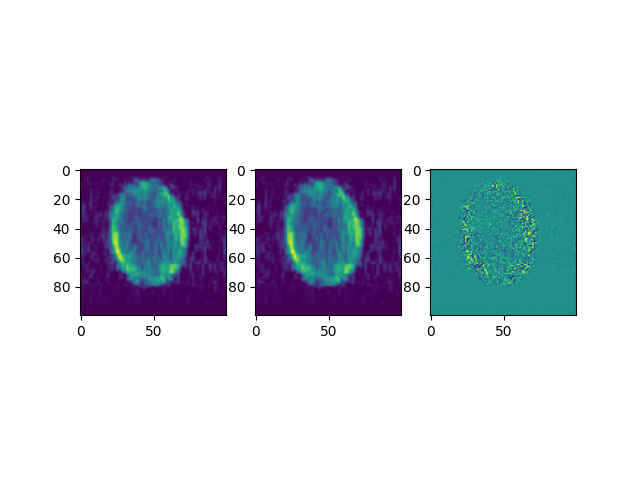

tensor(0)
tensor(1381.4630)


In [29]:
import matplotlib.pyplot as plt

idx = 0
fig, axes = plt.subplots(1,3)
idx = 30
B = next(enumerate(data_loader))[1]
axes[0].imshow(B[0][idx,:].view(100,-1))
axes[1].imshow(train_np[idx,:].reshape(100,-1))
axes[2].imshow(B[0][idx,:].view(100,-1)-train_np[idx,:].reshape(100,-1))
print(B[1][idx])
print(B[0][idx].sum())

# Check nonlinearity

<IPython.core.display.Javascript object>


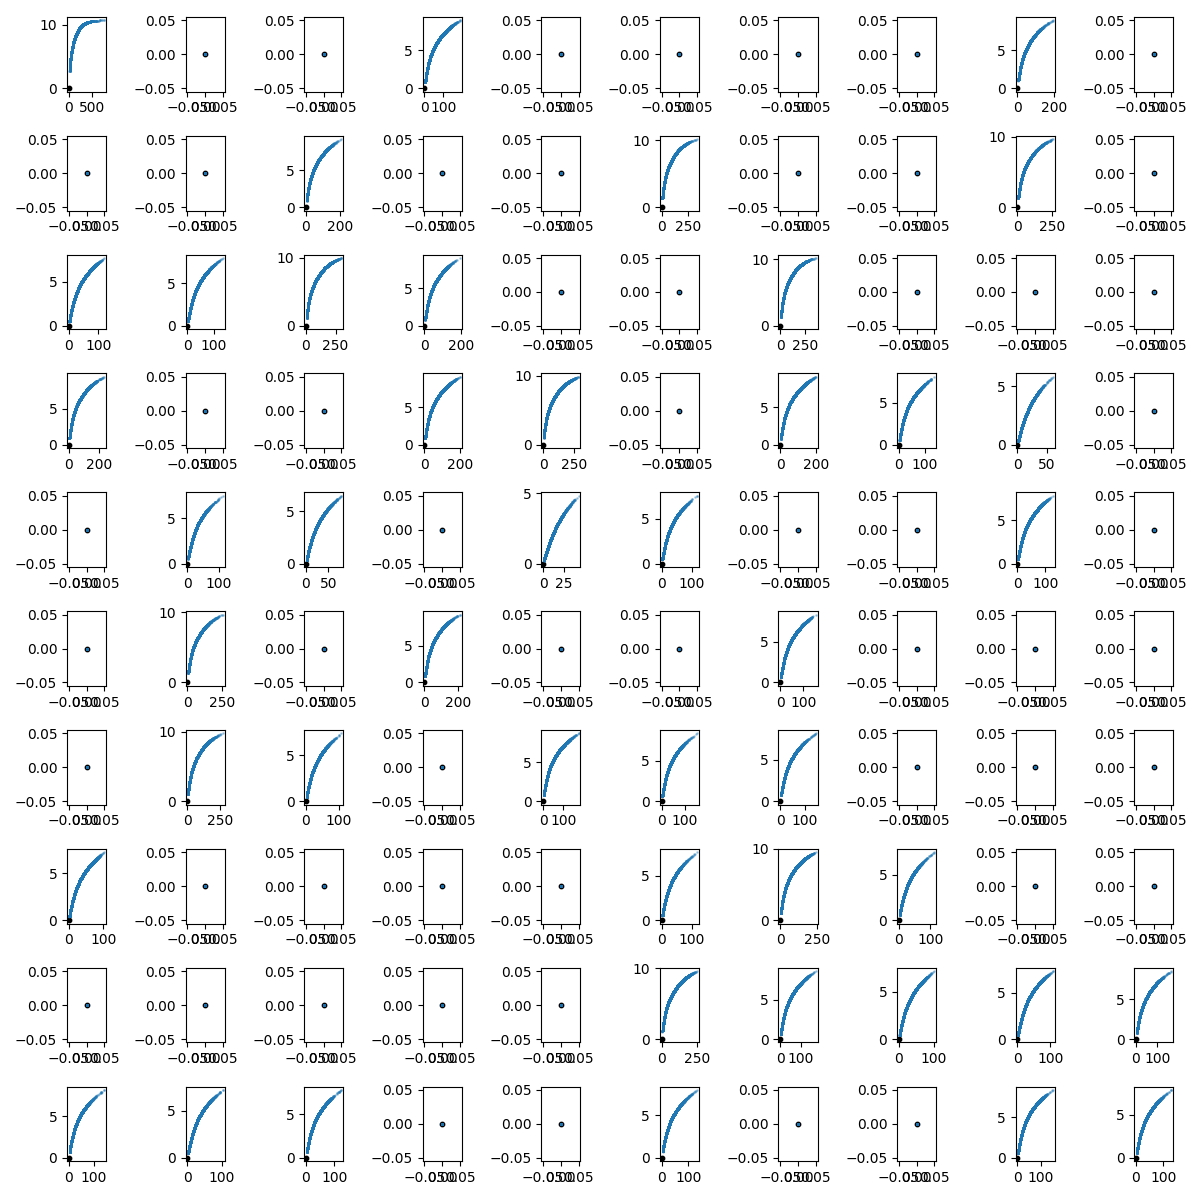

In [106]:
from scipy.optimize import curve_fit

def func2(x, b, c, d, e):
    return (-1.*b*np.exp(-c*x) - d*np.exp(-e*x) + b + d)

coeffs_refit = np.load('./Nonlinearity_Curves_April_8_data_refit.npz')['coeffs']

fig, axes = plt.subplots(10, 10, figsize = (12, 12))
x0 = torch.arange(0, 400/10, 0.1)
# y0s = model.encoder_nn[1](x0.tile(100,1).T)
# p0s = np.ones((36,4))
# p0s[0,:] = [20, 4, 0, 10]
# p0s[3,:] = [10, 1/3, 1, 1]
# p0s[5,:] = [20, 1/3, 1, 1]
# p0s[8,:] = [100, 1/100, 0, 1]
# p0s[12,:] = [10, 1/2, 0, 1]
# p0s[19,:] = [10, 1/2, 0, 1]
# p0s[23,:] = [20, 1/2, 0, 1]
# p0s[33,:] = [10, 1/2, 0, 1]
# p0s[35,:] = [20, 1/2, 0, 1]
# p0s[:,1] = p0s[:,1]/100
# p0s[:,3] = p0s[:,3]/100
# T1_inv = lambda x: (x+7843.875)/2986.897
# T2_inv = lambda x: x/156575.98
# coeffs_new = np.zeros(p0s.shape)
for k in range(100):
    i = k//10
    j = k%10
    ax = axes[i,j]
#     ax.plot(x0, y0s[:,k], 'r')
    ax.scatter(0, 0, s=10, c='k')
    x = hkfc1.output[:,k].detach().numpy()
#     y = model.encoder_nn[1](hkfc1.output[:,k]).detach().numpy()
    y = hkact1.output[:,k].detach().numpy()
    ax.scatter(x, y, s=1, alpha=0.3)
#     ax.set_xlabel('Input Intensity')
#     ax.set_ylabel('Output Intensity')
#     popt, _ = curve_fit(func2, x, y, p0=p0s[k,:], maxfev=5000)
#     print(popt)
#     coeffs_new[k,:] = popt
#     coeffs_new[k,0] = coeffs_new[k,0]*50
#     coeffs_new[k,2] = coeffs_new[k,2]*50
#     ax.plot(x0, func2(x0, *coeffs_new[k,:])/50, 'r--')
#     ax.plot(x0, func2(x0, *coeffs_orig[k,:])/50, 'b')
    

        #ax[i, j].set_xticks([])
        #ax[i, j].set_yticks([])
#plt.savefig('Old_intensifier_nonlinearity', dpi = 1200)
plt.tight_layout()
plt.show()

# Test Runs

In [13]:
args.wandb = True

# model = digitalClassifier([100**2, 1000, 500, 10])
model = OpticalClassifier([100**2, 200])

# with torch.no_grad():
#     model.encoder_nn[0].W_Opt.copy_(torch.tensor(H1/3.2))
#     model.encoder_nn[2].W_Opt.copy_(torch.tensor(H2/10))
#     model.encoder_nn[4].W_Opt.copy_(torch.tensor(H3/10))
    
# model.encoder_nn[0].W_Opt.requires_grad = False
# model.encoder_nn[2].W_Opt.requires_grad = False
# model.encoder_nn[4].W_Opt.requires_grad = False

if args.cuda:
    torch.cuda.set_device(0)
    model.cuda() # transfer the model from cpu to gpu
    
if args.wandb:
    wandb.init(project="Jun_16_fulcell_linear", name="Linear_reduced2_200_b128_AdamW_lr_0.0005_betas_0.999_0.999", reinit=True)
    wandb.watch(model, log="all")

# Configure loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5E-4, betas=(0.999, 0.999), weight_decay=0e-4)

# Loop around epoches
train_loader.batch_sampler.batch_size = 128
for epoch in range(1, 1000):
#     if epoch > 3000:
#          model.encoder_nn[0].W_Opt.requires_grad = True
    train(epoch, model, optimizer, criterion, train_loader)
    loss = test(epoch, model, criterion, val_loader)

accuracy,▁▃▆▄▆▆█
batch,███████▁
train_loss,▃█▃▄▃▂▂▁
val_loss,█▅▃▄▂▂▁
accuracy,69.27122
batch,396
train_loss,0.96421
val_loss,1.09448


Train Epoch: 1 		Loss: 1.007949	Accuracy:  55.49%

Test set: Epoch 1, Average loss: 1.2760, Accuracy: 10561/17303(61%)

Train Epoch: 2 		Loss: 1.208605	Accuracy:  64.98%

Test set: Epoch 2, Average loss: 1.2218, Accuracy: 10699/17303(62%)

Train Epoch: 3 		Loss: 1.372485	Accuracy:  66.31%

Test set: Epoch 3, Average loss: 1.1522, Accuracy: 11623/17303(67%)

Train Epoch: 4 		Loss: 1.157270	Accuracy:  68.35%

Test set: Epoch 4, Average loss: 1.1304, Accuracy: 11761/17303(68%)

Train Epoch: 5 		Loss: 1.138044	Accuracy:  69.00%

Test set: Epoch 5, Average loss: 1.1512, Accuracy: 11118/17303(64%)

Train Epoch: 6 		Loss: 1.193160	Accuracy:  69.11%

Test set: Epoch 6, Average loss: 1.0961, Accuracy: 11648/17303(67%)

Train Epoch: 7 		Loss: 0.767008	Accuracy:  70.75%

Test set: Epoch 7, Average loss: 1.1061, Accuracy: 11956/17303(69%)

Train Epoch: 8 		Loss: 0.850787	Accuracy:  71.35%

Test set: Epoch 8, Average loss: 1.0808, Accuracy: 12014/17303(69%)

Train Epoch: 9 		Loss: 1.146650	Accuracy


Train Epoch: 135 		Loss: 0.636205	Accuracy:  81.03%

Test set: Epoch 135, Average loss: 1.1051, Accuracy: 12074/17303(70%)

Train Epoch: 136 		Loss: 0.775001	Accuracy:  81.76%

Test set: Epoch 136, Average loss: 1.0405, Accuracy: 12503/17303(72%)

Train Epoch: 137 		Loss: 0.402949	Accuracy:  82.55%

Test set: Epoch 137, Average loss: 1.0183, Accuracy: 12373/17303(72%)

Train Epoch: 138 		Loss: 0.524515	Accuracy:  82.64%

Test set: Epoch 138, Average loss: 1.0464, Accuracy: 12519/17303(72%)

Train Epoch: 139 		Loss: 0.515747	Accuracy:  81.90%

Test set: Epoch 139, Average loss: 1.0495, Accuracy: 12261/17303(71%)

Train Epoch: 140 		Loss: 0.887806	Accuracy:  81.61%

Test set: Epoch 140, Average loss: 1.0609, Accuracy: 12251/17303(71%)

Train Epoch: 141 		Loss: 0.575276	Accuracy:  82.06%

Test set: Epoch 141, Average loss: 1.0961, Accuracy: 12029/17303(70%)

Train Epoch: 142 		Loss: 0.638364	Accuracy:  81.36%

Test set: Epoch 142, Average loss: 1.0557, Accuracy: 12359/17303(71%)

Train E

Train Epoch: 267 		Loss: 0.408270	Accuracy:  82.43%

Test set: Epoch 267, Average loss: 1.1665, Accuracy: 12198/17303(70%)

Train Epoch: 268 		Loss: 0.499943	Accuracy:  81.87%

Test set: Epoch 268, Average loss: 1.1371, Accuracy: 11946/17303(69%)

Train Epoch: 269 		Loss: 0.667579	Accuracy:  82.87%

Test set: Epoch 269, Average loss: 1.1298, Accuracy: 12219/17303(71%)

Train Epoch: 270 		Loss: 0.509102	Accuracy:  83.55%

Test set: Epoch 270, Average loss: 1.1760, Accuracy: 11904/17303(69%)

Train Epoch: 271 		Loss: 0.526582	Accuracy:  83.45%

Test set: Epoch 271, Average loss: 1.1403, Accuracy: 12035/17303(70%)

Train Epoch: 272 		Loss: 0.560071	Accuracy:  84.11%

Test set: Epoch 272, Average loss: 1.1374, Accuracy: 12136/17303(70%)

Train Epoch: 273 		Loss: 0.547239	Accuracy:  83.95%

Test set: Epoch 273, Average loss: 1.1122, Accuracy: 12253/17303(71%)

Train Epoch: 274 		Loss: 0.423593	Accuracy:  83.83%

Test set: Epoch 274, Average loss: 1.1321, Accuracy: 12307/17303(71%)

Train Ep

KeyboardInterrupt: 

In [89]:
args.wandb = True

model = OpticalVAE([64**2, 100, 8])
# with torch.no_grad():
#     model.encoder_nn[0].W_Opt.copy_(torch.tensor(H1/3.2))
#     model.encoder_nn[2].W_Opt.copy_(torch.tensor(H2/10))
#     model.encoder_nn[4].W_Opt.copy_(torch.tensor(H3/10))
    
# model.encoder_nn[0].W_Opt.requires_grad = False
# model.encoder_nn[2].W_Opt.requires_grad = False
# model.encoder_nn[4].W_Opt.requires_grad = False

if args.cuda:
    torch.cuda.set_device(2)
    model.cuda() # transfer the model from cpu to gpu
    
if args.wandb:
    wandb.init(project="Jun_5_face_VAE_manual", name="DigiFC_reluAct_100_8_500_div1_L1_KL1E-6_b32_AdamW_lr_0.0002_beta_0.99_0.999", reinit=True)
    wandb.watch(model, log="all")

# Configure loss function and optimizer
#criterion = nn.CrossEntropyLoss()
criterion = nn.L1Loss(reduction='mean')
#criterion = nn.MSELoss(reduction='mean')
#criterion = nn.BCELoss(reduction='mean')
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0002, betas=(0.99, 0.999), weight_decay=0e-4)

# Loop around epoches
for epoch in range(1, 5000):
#     if epoch > 3000:
#          model.encoder_nn[0].W_Opt.requires_grad = True
    train(epoch, model, optimizer, criterion, train_loader, kll_weight=1E-6)
    loss, _, _, _ = test(epoch, model, criterion, test_loader, kll_weight=1E-6)

KL_loss,▁▁▂▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇███████████████
Lag_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_loss,█▅▃▂▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
batch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,██▆▄▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▂
KL_loss,1919.96777
Lag_loss,0.0
MSE_loss,0.06605
batch,9
train_loss,0.01591



Test set: Epoch 100, Average loss: 0.0884 + 0.000001 * 62.1019 + 0.000000 * 0.0000 = 0.0885


Test set: Epoch 200, Average loss: 0.0774 + 0.000001 * 157.8474 + 0.000000 * 0.0000 = 0.0776


Test set: Epoch 300, Average loss: 0.0729 + 0.000001 * 278.9461 + 0.000000 * 0.0000 = 0.0732


Test set: Epoch 400, Average loss: 0.0702 + 0.000001 * 433.9286 + 0.000000 * 0.0000 = 0.0707


Test set: Epoch 500, Average loss: 0.0689 + 0.000001 * 573.2519 + 0.000000 * 0.0000 = 0.0694


Test set: Epoch 600, Average loss: 0.0677 + 0.000001 * 699.2416 + 0.000000 * 0.0000 = 0.0684


Test set: Epoch 700, Average loss: 0.0670 + 0.000001 * 821.0417 + 0.000000 * 0.0000 = 0.0679


Test set: Epoch 800, Average loss: 0.0671 + 0.000001 * 922.4039 + 0.000000 * 0.0000 = 0.0680


Test set: Epoch 900, Average loss: 0.0674 + 0.000001 * 1028.8016 + 0.000000 * 0.0000 = 0.0685


Test set: Epoch 1000, Average loss: 0.0664 + 0.000001 * 1128.1584 + 0.000000 * 0.0000 = 0.0675


Test set: Epoch 1100, Average loss: 0.0667 + 0.

In [101]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, f"./RescaleNL_Pretrain_144_72_36_500_div1_L1_KL1E-6_b32_AdamW_lr_0.001_beta_0.99_0.999.pt")

# Visualize Results

In [28]:
%matplotlib notebook

In [37]:
B = next(enumerate(val_loader))[1]
test_images = B[0].to(device="cpu")
test_labels = B[1]

## 10000-200-10:=10 (These accuracies are high since the old train data contains some new test data)

In [80]:
model = OpticalClassifier([100**2, 200, 10])
model_ckpt = torch.load("./Classifier_200_10_b64_AdamW_lr_0.002255_bs_64_betas_0.9998_0.9994_v_23/ep492.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [93]:
import matplotlib.pyplot as plt

model.cpu()
pred = model(test_images).data.max(1, keepdim=True)[1] # get the index of the max log-probability
correct = pred.eq(test_labels.data.view_as(pred)).cpu().sum()
accuracy = 100. * correct / len(test_labels)
print(correct, accuracy)

tensor(8637) tensor(92.8710)


## 10000-200-10:=10 (These accuracies are high since the old train data contains some new test data)

In [94]:
model = OpticalClassifier([100**2, 200, 10])
model_ckpt = torch.load("./Classifier_200_10_b32_AdamW_lr_0.000853_bs_32_betas_0.9997_0.9994_v_19/ep481.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [98]:
import matplotlib.pyplot as plt

model.cpu()
pred = model(test_images).data.max(1, keepdim=True)[1] # get the index of the max log-probability
correct = pred.eq(test_labels.data.view_as(pred)).cpu().sum()
accuracy = 100. * correct / len(test_labels)
print(correct, accuracy)

tensor(8516) tensor(91.5699)


## 10000-200-10:=10

In [49]:
model = OpticalClassifier([100**2, 200, 10])
model_ckpt = torch.load("./Classifier_200_10_b32_AdamW_lr_0.000427_bs_32_betas_0.9997_0.9994_v_3/ep495.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [55]:
model.cpu()
pred = model(test_images).data.max(1, keepdim=True)[1] # get the index of the max log-probability
correct = pred.eq(test_labels.data.view_as(pred)).cpu().sum()
accuracy = 100. * correct / len(test_labels)
print(correct, accuracy)

tensor(825) tensor(82.5000)


## 10000-400-40:=10 

In [42]:
model = OpticalClassifier([100**2, 400, 40])
model_ckpt = torch.load("./Classifier_400_40_b64_AdamW_lr_0.001041_bs_64_betas_0.9991_0.9996_v_48/ep484.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [48]:
import matplotlib.pyplot as plt

model.cpu()
pred = model(test_images).data.max(1, keepdim=True)[1] # get the index of the max log-probability
correct = pred.eq(test_labels.data.view_as(pred)).cpu().sum()
accuracy = 100. * correct / len(test_labels)
print(correct, accuracy)

tensor(823) tensor(82.3000)


# Plots

In [71]:
%matplotlib notebook

<IPython.core.display.Javascript object>


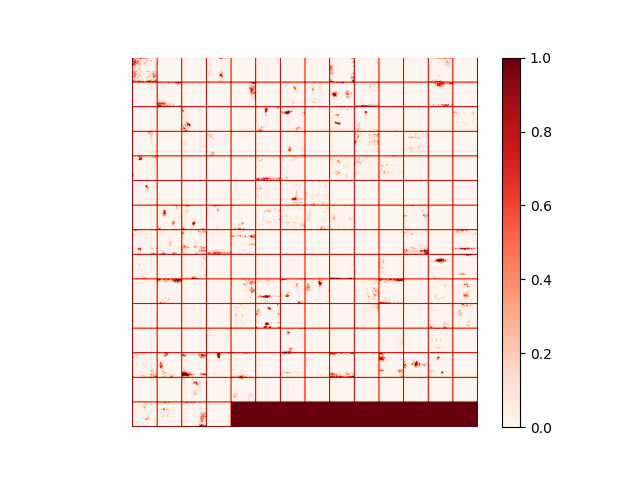

In [105]:
import torchvision

W = model.encoder_nn[0].W_Opt.to(device='cpu')
W = W.view(-1,1,100,100)
W = W.repeat(1,3,1,1)
W_vis = torchvision.utils.make_grid(W, padding=4, pad_value=1, nrow=14)
plt.figure()
plt.imshow(W_vis[0,:,:].detach().numpy(), cmap="Reds")
plt.axis("off")
plt.colorbar()
plt.show()
#plt.savefig(f"./figures/publish/fcs_0_weights.svg", dpi=300, format="svg")

<IPython.core.display.Javascript object>


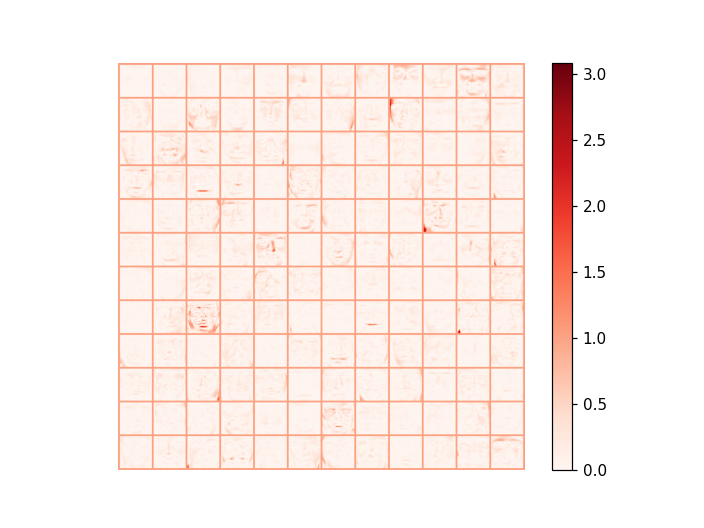

In [79]:
import torchvision

W = torch.tensor(H1)
W = W.view(-1,1,64,64)
W = W.repeat(1,3,1,1)
W_vis = torchvision.utils.make_grid(W, padding=4, pad_value=1, nrow=12)
plt.figure()
plt.imshow(W_vis[0,:,:].detach().numpy(), cmap="Reds")
plt.axis("off")
plt.colorbar()
plt.show()
#plt.savefig(f"./figures/publish/fcs_0_weights.svg", dpi=300, format="svg")

<IPython.core.display.Javascript object>


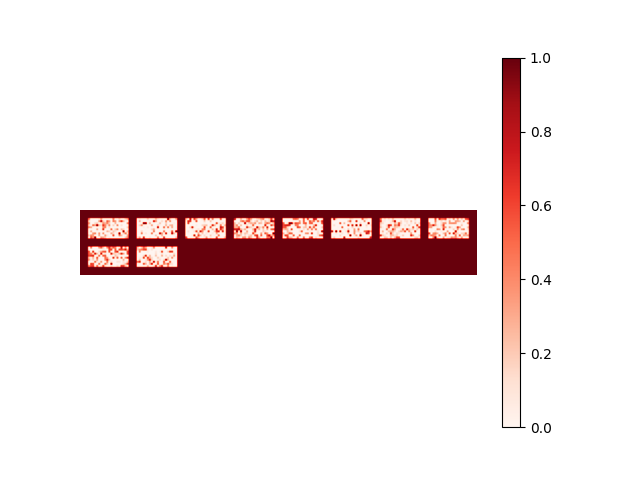

In [95]:
import torchvision

W = model.encoder_nn[2].W_Opt.to(device='cpu')
W = W.view(-1,1,10,20)
W = W.repeat(1,3,1,1)
W_vis = torchvision.utils.make_grid(W, padding=4, pad_value=1, nrow=8)
plt.figure()
plt.imshow(W_vis[0,:,:].detach().numpy(), cmap="Reds")
plt.axis("off")
plt.colorbar()
plt.show()
#plt.savefig(f"./figures/publish/fcs_0_weights.svg", dpi=300, format="svg")

In [33]:
print(torch.__version__, optuna.__version__, ray.__version__)

1.11.0+cu102 1.5.0 1.11.0
